# Ground state of the harmonic oscillator

This notebook demonstrates the calculation of the ground state of the harmonic oscillator in one dimensions.
It uses three different models for calculating the interaction between worlds:

* the original MIW toy model introduced by Hall et al.
* a Gauss interpolation method to derive a smooth density based on the worlds position
* an adaptive kernel density estimate using Gaussian kernels and a width based on a nearest neighbor distance


In [1]:
%pylab inline
%cd lib
!python3 setup.py build_ext --inplace

Populating the interactive namespace from numpy and matplotlib
/workspace/1D/lib
running build_ext


In [2]:
import sys
sys.path.append('./lib/')
import QMbasics as QM
#importing all different implementations
from Pgaussinterpolation import Pgaussinterpolation
from Pgaussnearestneighbour import Pgaussnearestneighbour
from MIWorig import MIWorig

In [3]:
n=1
N=20
worlds = linspace(-2.5,2.5,N)

state = QM.HarmonicStationaryState(n)
groundstate = QM.HarmonicStationaryState(0)
phase = np.array(np.sign(state.psi_(worlds)),dtype=np.int)
algorithms = {}
algorithms["MIW toy model"] = MIWorig(worlds)
algorithms["Gaussinterpolation"] = Pgaussinterpolation(worlds,recursive_interpolation=30)
algorithms["Adaptive kernel $h_i=\sqrt{\mathrm{nndist}_i}$"] = Pgaussnearestneighbour(worlds)


0
0


### density profile before groundstate algorithm

In [4]:
x = linspace(-4.,4.,1000)

Intial pdata:

In [5]:
pinitialx = {key: alg.p_eval_vec(x) for (key,alg) in algorithms.items()}
pinitialworlds = {key: alg.p_eval_vec(worlds) for (key,alg) in algorithms.items()}
worldsinitial = worlds.copy()

Carrying out the algorithm:

In [6]:
dt = 7e-3
NumIterations=200000
OutputEvery=1000
result = {}
for i,alg in algorithms.items():
    print(i)
    result[i]=alg.update(dt=dt, NumIterations=NumIterations, OutputEvery=OutputEvery)

MIW toy model
0%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%
Gaussinterpolation
0%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%
Adaptive kernel $h_i=\sqrt{\mathrm{nndist}_i}$
0%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%


In [7]:
pfinalx = {key: alg.p_eval_vec(x) for (key,alg) in algorithms.items()}
pfinalworlds = {key: alg.p_eval_vec(alg.worlds) for (key,alg) in algorithms.items()}
worldsfinal = {key: alg.worlds for (key,alg) in algorithms.items()}

Plotting results:

In [8]:
keys = list(algorithms.keys())

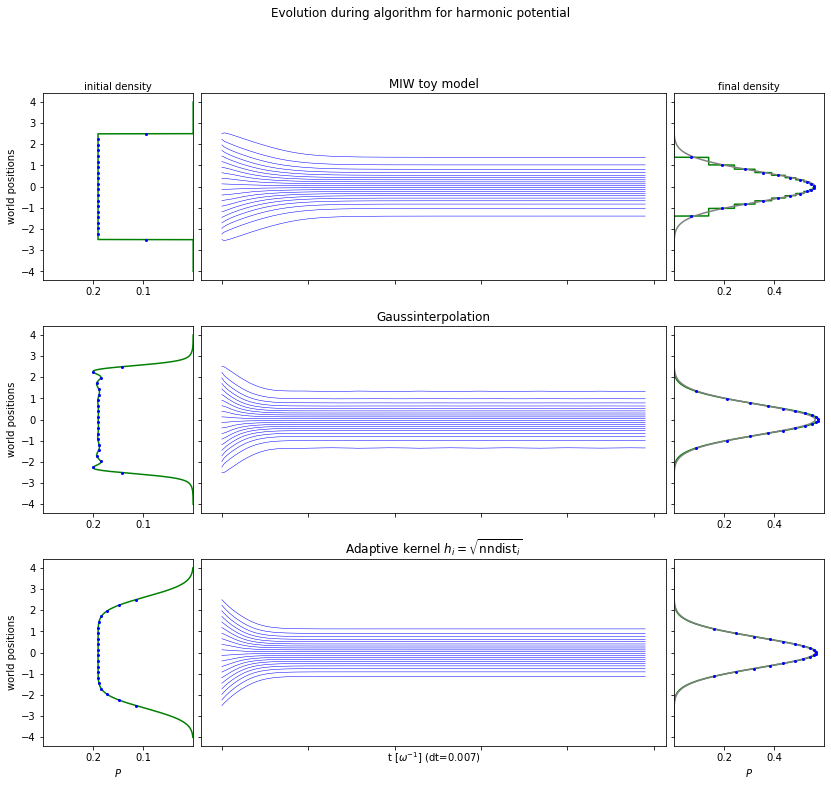

In [9]:
keys = list(algorithms.keys())
nalgs = len(algorithms)
import matplotlib.gridspec as gridspec
fig = figure(figsize=(14,4*nalgs))
fig.suptitle("Evolution during algorithm for harmonic potential")
gs = gridspec.GridSpec(nalgs,5,wspace=0.05,hspace=0.25)
axes = {}
rows = {}
for i in range(nalgs):
    axm = plt.subplot(gs[i,1:-1])
    axl = plt.subplot(gs[i,0],sharey=axm)
    axr = plt.subplot(gs[i,-1],sharey=axm)
    axes[keys[i]] = axl, axm, axr
    rows[keys[i]] = i

def plot_key(key):

    axpfromworlds, ax, axpfromworldsend  = axes[key]
    res=result[key]
    #fig = figure(figsize=(7,4.5))
    #fig.suptitle("Groundstatealgorithm for harmonic potential with $N=40$ worlds")
    #ax = fig.add_subplot(111)
    ax.set_title(key)
    ax.plot(res[1],res[0],color='blue',lw=0.5);
    plt.style.use({"lines.markersize":2})

    #ax.set_ylabel('worlds N={}'.format(N))

    axorig=ax
    plt.setp(axpfromworldsend.get_yticklabels()+axorig.get_yticklabels() +axorig.get_xticklabels(),
            visible=False)


    axpfromworlds.plot( pinitialx[key],x,color='green',label="density\nestimate")
    axpfromworlds.plot(pinitialworlds[key],worldsinitial,"o",color='blue', label="worlds")
    #axpfromworlds.legend(loc="upper left",fontsize=8)

    #axpfromworlds.plot(groundstate.p_(x),x,"--",color='gray')
    #axpfromworlds.plot(state.p_(x),x,"--",color='gray')

    axpfromworlds.set_xlim(0,0.3)
    axpfromworlds.set_ylabel('world positions'.format(N))
    axpfromworlds.invert_xaxis()
    axpfromworlds.set_xticks([0.1,0.2])

    axpfromworldsend.plot(pfinalx[key],x,color='green')
    axpfromworldsend.plot(groundstate.p_(x),x,"-",color='gray', label="exact\ngroundstate")
    axpfromworldsend.plot(pfinalworlds[key],worldsfinal[key],"o",color='blue')
    #axpfromworldsend.legend(loc='upper right',fontsize=8)
    axpfromworldsend.set_xlim(0,0.6)


    axpfromworldsend.set_xticks([0.2,0.4])

    if rows[key] == 0:
        axpfromworlds.xaxis.set_label_position('top')
        axpfromworldsend.xaxis.set_label_position('top') 

        axpfromworlds.set_xlabel("initial density")
        axpfromworldsend.set_xlabel("final density")
    if rows[key] == nalgs-1:
        axpfromworlds.set_xlabel("$P$")
        axpfromworldsend.set_xlabel("$P$")
        plt.setp(ax.get_xticklabels(),visible=True)
        ax.set_xlabel('t [$\omega^{-1}$]'+' (dt={})'.format(dt))


for key in keys:
    plot_key(key)


Text(0.5, 1.0, 'Relative error')

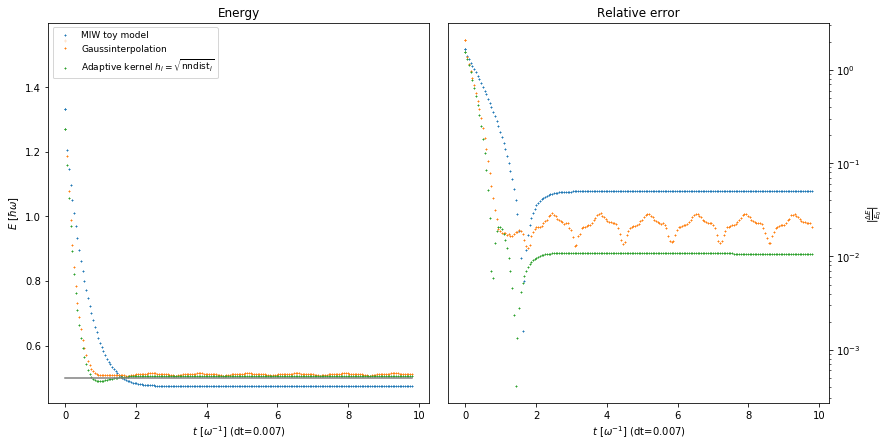

In [10]:
fig = figure(figsize(14,7))
gs = gridspec.GridSpec(1,2,wspace=0.05)
ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

plt.sca(ax[0])
for key in keys:
    plot(result[key][1],result[key][2],"+",label=key)
plot(result[key][1],np.ones_like(result[key][1])*0.5,"-",color="grey")

legend(fontsize=9,loc="upper left")
title("Energy")
xlabel('$t$ [$\omega^{-1}$]'+' (dt={})'.format(dt))
ylabel('$E$ [$\hbar \omega$]')
plt.sca(ax[1])

for key in keys:
    plot(result[key][1],np.abs(result[key][2]-0.5)/0.5,"+",label=key)
xlabel(r'$t$ [$\omega^{-1}$]'+' (dt={})'.format(dt))
ylabel(r'$\left|\frac{\Delta E}{E_0}\right|$ ',)
yscale('log')
title("Relative error")